In [1]:
import os
import sys
import gc

import scipy.stats as stats
import scvi
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from fast_matrix_market import mmread

import scipy
from scipy.spatial.distance import jensenshannon
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams

import torch
import cell2location

# Set matplotlib parameters
rcParams['pdf.fonttype'] = 42  # Enables correct plotting of text for PDFs

/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated.

In [2]:
def load_wu_data(path, test_mode=False):
    matrix_path = os.path.join(path, "matrix.mtx")
    genes_path = os.path.join(path, "genes.tsv")
    barcodes_path = os.path.join(path, "barcodes.tsv")
    metadata_path = os.path.join(path, "metadata.csv")
    try:
        genes_df = pd.read_csv(genes_path, header=None, sep="\t")
        barcodes_df = pd.read_csv(barcodes_path, header=None)
        barcodes = barcodes_df[0]

        matrix = mmread(matrix_path).T.tocsc().tocsr().astype("float32")
        var_df = pd.DataFrame(index=genes_df[0])
        
        # Create the initial AnnData object
        adata = AnnData(
            matrix, obs=pd.DataFrame(index=barcodes), var=var_df
        )

        # Load the metadata
        metadata_df = pd.read_csv(metadata_path, index_col=0)
        adata.obs['patient_ID'] = metadata_df['orig.ident']
        adata.obs['celltype']   = metadata_df['celltype_major']
        adata.obs["tissue"]     = "Cancer"
        adata.obs["subtype"]    = metadata_df['subtype']
        adata.obs.index.name = None
        if test_mode:
            # Downsample in test mode
            adata = adata[np.random.choice(adata.shape[0], 10000, replace=False)]

        return adata

    except Exception as e:
        print("Error in load_wu_data function:", e)
        raise
wu_path = "/bgfs/alee/LO_LAB/General/Public_Data/BC-Datasets/Wu_2021/Wu_etal_2021_BRCA_scRNASeq"
test_mode = False

# load the ER+ reference dataset
wu_adata = load_wu_data(wu_path, test_mode)
wu_adata

AnnData object with n_obs × n_vars = 100064 × 29733
    obs: 'patient_ID', 'celltype', 'tissue', 'subtype'

In [4]:
# subset Wu object to ER+ cells
wu_adata = wu_adata[wu_adata.obs['subtype'] == "ER+"]
wu_adata.var.index.name = "Index"
from cell2location.utils.filtering import filter_genes
adata_ref = wu_adata.copy()

adata_ref.var

""
Index
RP11-34P13.7
FO538757.3
FO538757.2
AP006222.2
RP4-669L17.10
...
RP11-983C2.3
LINC00919
RP11-589P10.7


In [12]:
[gene.startswith('MT-') for gene in adata_ref.var_names]

True

/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/cell2location/utils/filtering.py:26: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = np.array((adata.X > 0).sum(0)).flatten()
/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


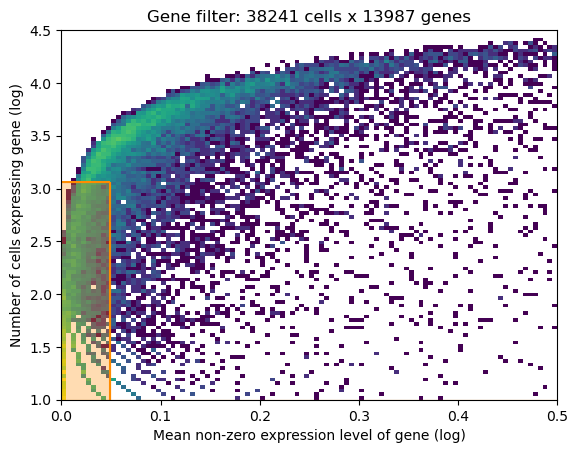

AnnData object with n_obs × n_vars = 38241 × 13987
    obs: 'patient_ID', 'celltype', 'tissue', 'subtype'
    var: 'MT_gene', 'n_cells', 'nonz_mean'
    obsm: 'MT'

In [14]:
# find mitochondria-encoded (MT) genes
adata_ref.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_ref.var_names]

# remove MT genes for spatial mapping (keeping their counts in the object)
adata_ref.obsm['MT'] = adata_ref[:, adata_ref.var['MT_gene'].values].X.toarray()
adata_ref = adata_ref[:, ~adata_ref.var['MT_gene'].values]

selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)

# filter the object
adata_ref = adata_ref[:, selected].copy()
adata_ref

In [15]:
results_folder = '/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [16]:
# prepare anndata for the regression model
TF_CPP_MIN_LOG_LEVEL=0
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                        batch_key='patient_ID',
                        # cell type, covariate used for constructing signatures
                        labels_key='celltype',
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['patient_ID']
                       )

CUDA backend failed to initialize: Unable to load cuDNN. Is it installed? (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [17]:
# create the regression model
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)

# view anndata_setup as a sanity check
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'patient_ID',
│   'labels_key': 'celltype',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │  11   │
│         n_cells          │ 38241 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   9   │
│          n_vars          │ 13987 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['patient_ID'] │  CID3941   │          0          │
│                         │  CID3948   │          1          │
│                         │  CID4040   │          2          │
│                         │  CID4067   │          3          │
│                         │  CID4290A  │          4          │
│                         │  CID4398   │          5          │
│                         │  CID4461   │          6          │
│                         │  CID4463   │          7          │
│                         │  CID4471   │          8          │
│                         │  CID4530N  │          9          │
│                         │  CID4535   │         10          │
└─────────────────────────┴────────────┴─────────────────────┘

                       labels State Registry                       
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃    Categories     ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['celltype'] │      B-cells      │          0          │
│                       │       CAFs        │          1          │
│                       │ Cancer Epithelial │          2          │
│                       │    Endothelial    │          3          │
│                       │      Myeloid      │          4          │
│                       │ Normal Epithelial │          5          │
│                       │        PVL        │          6          │
│                       │   Plasmablasts    │          7          │
│                       │      T-cells      │          8          │
└───────────────────────┴───────────────────┴─────────────────────┘

In [18]:
mod.train(max_epochs=250, use_gpu = True)

/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision 

Epoch 250/250: 100%|██████████| 250/250 [05:46<00:00,  1.36s/it, v_num=1, elbo_train=2.22e+8]

`Trainer.fit` stopped: `max_epochs=250` reached.


Epoch 250/250: 100%|██████████| 250/250 [05:46<00:00,  1.39s/it, v_num=1, elbo_train=2.22e+8]


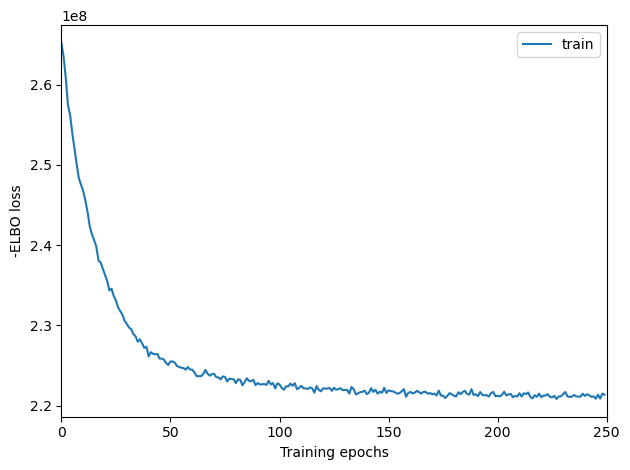

In [19]:
mod.plot_history()

In [23]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)
# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/reference_major.h5ad"
adata_ref.write(adata_file)
adata_file

/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/envs/CITEgeist/lib/python3.10/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:07<00:00, 129.27it/s]


'/bgfs/alee/LO_LAB/Personal/Brent_Schlegel/Projects/Wu_Visium/Simulations/larger_ref/reference_signatures/reference_major.h5ad'

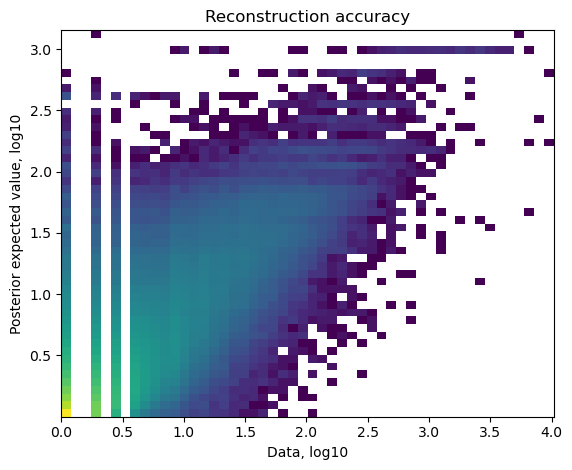

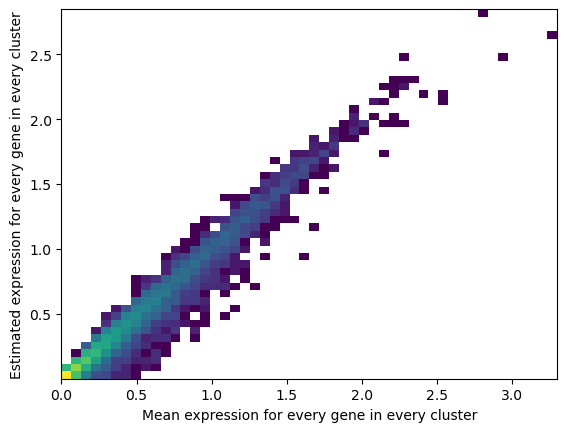

In [24]:
mod.plot_QC()

In [25]:
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}'
                                    for i in adata_ref.uns['mod']['factor_names']]].copy()
inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B-cells,CAFs,Cancer Epithelial,Endothelial,Myeloid
Index,,,,,
FO538757.2,0.019655,0.083765,0.211800,0.110907,0.083614
AP006222.2,0.004130,0.066931,0.064820,0.050288,0.045956
RP11-206L10.9,0.008195,0.015940,0.070035,0.012141,0.025931
SAMD11,0.002892,0.141871,0.004970,0.004846,0.001129
NOC2L,0.037867,0.119497,0.596733,0.184043,0.115509
